In [49]:
import numpy as np
import pandas as pd
from plotnine import *

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.stats import f

show_prints = 1

In [42]:
# Read CSV file
infections = pd.read_csv("../data/hospital_infection.csv")

# Display the first few rows
print(infections.head())

   ID   Stay   Age  InfctRsk  Culture   Xray  Beds  MedSchool  Region  Census  \
0   5  11.20  56.5       5.7     34.5   88.9   180          2       1     134   
1  10   8.84  56.3       6.3     29.6   82.6    85          2       1      59   
2  11  11.07  53.2       4.9     28.5  122.0   768          1       1     591   
3  13  12.78  56.8       7.7     46.0  116.9   322          1       1     252   
4  18  11.62  53.9       6.4     25.5   99.2   133          2       1     113   

   Nurses  Facilities  
0     151        40.0  
1      66        40.0  
2     656        80.0  
3     349        57.1  
4     101        37.1  


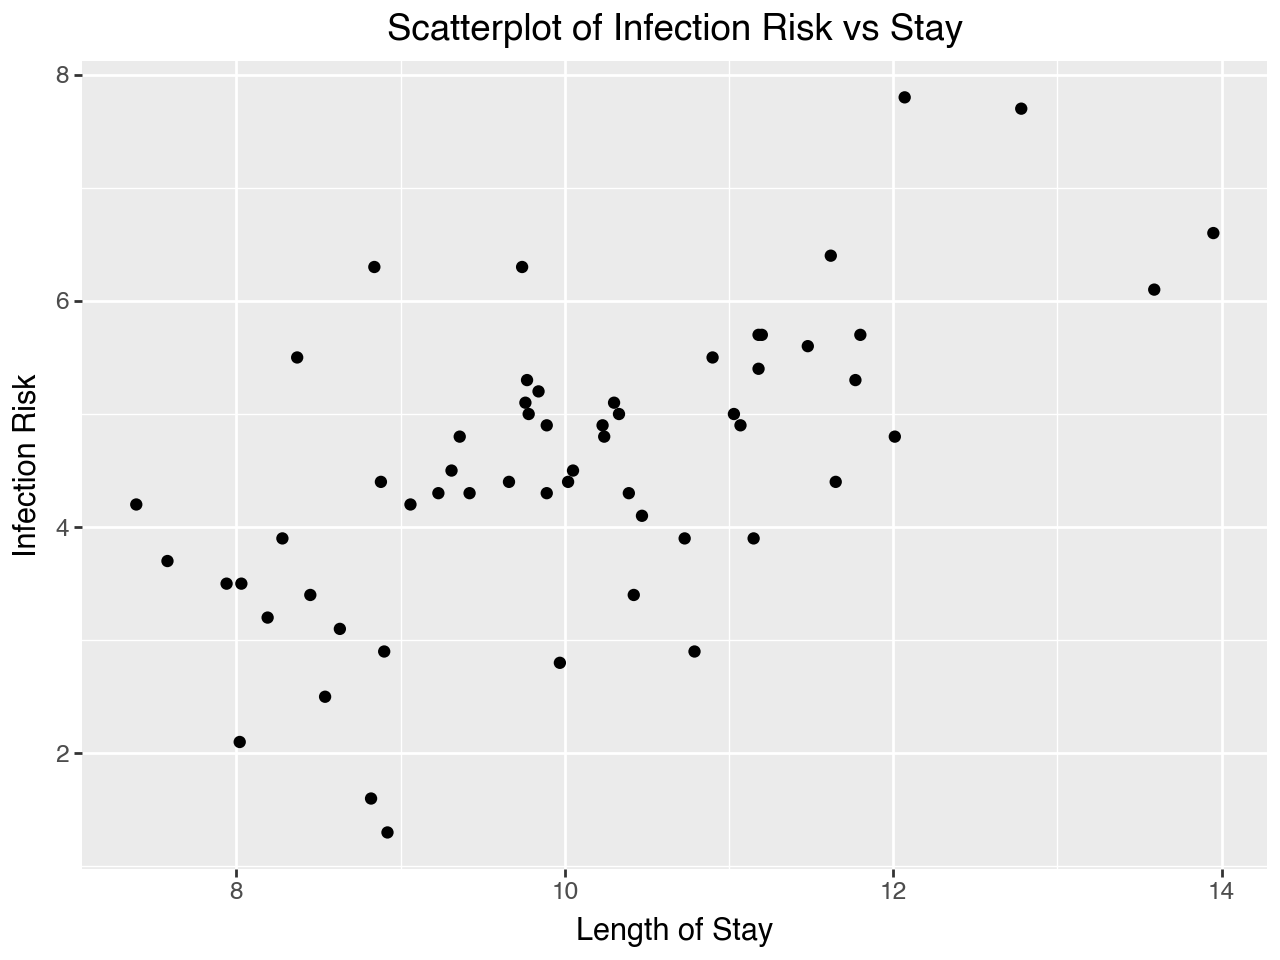

In [43]:
ggplot(infections, aes(x='Stay', y='InfctRsk')) + \
    geom_point() + \
    labs(title='Scatterplot of Infection Risk vs Stay', x='Length of Stay', y='Infection Risk') #label x and y axes in words


In [44]:
complete_index = infections.notnull().all(axis=1) #not null entries in all columns (axis = 1)

print(infections[~complete_index]) #~ is a negation operator  – switches True to False and vice versa

Empty DataFrame
Columns: [ID, Stay, Age, InfctRsk, Culture, Xray, Beds, MedSchool, Region, Census, Nurses, Facilities]
Index: []


In [45]:
def ss_decomp(X, y):

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Calculate the mean of y
    y_mean = np.mean(y)

    # calculate SS quantities
    SST = np.sum((y - y_mean) ** 2).round(4)
    SSR = np.sum((y_pred - y_mean) ** 2).round(4)
    SSE = np.sum((y - y_pred) ** 2).round(4)

    if show_prints:
        # Output the sum of squares decomposition
        print(f"SST (Total Sum of Squares): {SST}")
        print(f"SSR (Regression Sum of Squares): {SSR}")
        print(f"SSE (Error Sum of Squares): {SSE}")
        print(f"SST = SSR + SSE: {np.isclose(SST, SSR + SSE)}")
        print(
            f"Coefficient of Determination, R^2 is: {np.round(1-SSE/SST, 4)}")

    # F Test
    n = len(y)
    MSR = SSR / 1
    MSE = SSE / (n - 2)
    F_stat = MSR / MSE

    # Convert X, y, and y_pred to 1D arrays
    X_1d = X.squeeze()  # Ensure 'X' is a Series or 1D array
    y_1d = y.squeeze()  # Ensure 'y' is a Series or 1D array
    y_pred_1d = y_pred.flatten()  # Flatten the predicted values to 1D

    # Create the DataFrame for ggplot
    df = pd.DataFrame({
        'X': X_1d,
        'y': y_1d,
        'predicted': y_pred_1d,
        'y_mean': np.full_like(y_1d, y_mean)  # Array with mean values of y
    })

    gg1 = (
        ggplot(df, aes(x='X', y='y')) +
        geom_point() +
        # geom_smooth(method = "lm", formula = "y ~ x", se = False) +
        geom_hline(yintercept=y_mean, linetype='dashed') +
        # SST components
        geom_segment(aes(xend='X', yend='y_mean'), color="black") +
        ggtitle(f"R^2 is {np.round(1-SSE/SST, 4)}")
    )

    gg2 = (
        ggplot(df, aes(x='X', y='y')) +
        geom_point() +
        geom_smooth(method="lm", formula="y ~ x", se=False) +
        geom_hline(yintercept=y_mean, linetype='dashed') +
        # SSR components
        geom_segment(aes(xend='X', y='predicted', yend='y_mean'), color="blue", linetype="dashed") +
        # SSE components
        geom_segment(aes(xend='X',  yend='predicted'), color="red", linetype="dashed") +
        ggtitle(f"R^2 is {np.round(1-SSE/SST, 4)}")
    )

    return gg1, gg2, F_stat


def hypothesis_test(F_stat, n, alpha=0.05):

    # Degrees of freedom
    dfn = 1
    dfd = n - 2
    # Calculate the p-value using the cumulative distribution function (CDF) of the F-distribution
    p_value = 1 - f.cdf(F_stat, dfn, dfd)

    # Decision rule

    if p_value < alpha:
        decision = f"Reject the null hypothesis at alpha = {alpha}. There is evidence of a linear relationship."
    else:
        decision = f"Fail to reject the null hypothesis at alpha = {alpha}. No evidence of a linear relationship."

    if show_prints:
        print(f"F-statistic: {F_stat}")
        print(f"p-value: {p_value}")
        print(decision)

    return p_value, decision

In [72]:
# Fit linear model
X = infections[['Stay']]
y = infections[['InfctRsk']]
model = LinearRegression().fit(X, y)
# Linear model summary
slope = model.coef_[0]
intercept = model.intercept_
print(f"Slope: {slope}, Intercept: {intercept}")

Slope: [0.56886646], Intercept: [-1.15981903]


In [73]:

# Add constant to X for intercept
X_with_const = sm.add_constant(X)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, X_with_const).fit()

# Linear model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               InfctRsk   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     36.50
Date:                Sun, 08 Sep 2024   Prob (F-statistic):           1.30e-07
Time:                        22:27:45   Log-Likelihood:                -82.684
No. Observations:                  58   AIC:                             169.4
Df Residuals:                      56   BIC:                             173.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1598      0.956     -1.213      0.2

In [47]:
gg1, gg2, F_stat = ss_decomp(X, y)
n = len(X)
hypothesis_test(F_stat=F_stat, n=n, alpha=0.05)

SST (Total Sum of Squares): InfctRsk    97.0822
dtype: float64
SSR (Regression Sum of Squares): 38.3059
SSE (Error Sum of Squares): InfctRsk    58.7763
dtype: float64
SST = SSR + SSE: [ True]
Coefficient of Determination, R^2 is: InfctRsk    0.3946
dtype: float64
F-statistic: InfctRsk    36.49652
dtype: float64
p-value: [1.30245378e-07]
Reject the null hypothesis at alpha = 0.05. There is evidence of a linear relationship.


/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


(array([1.30245378e-07]),
 'Reject the null hypothesis at alpha = 0.05. There is evidence of a linear relationship.')

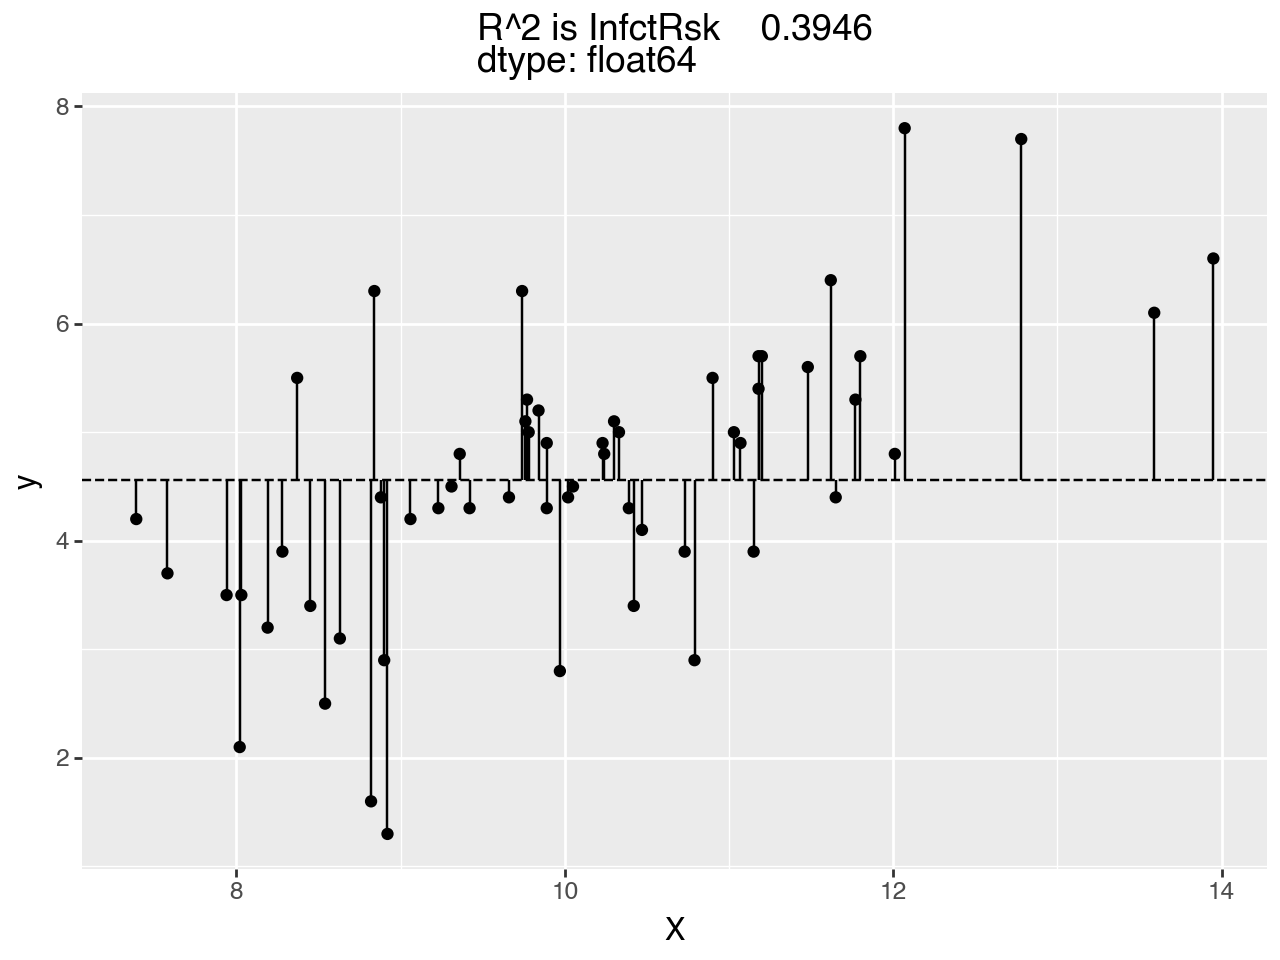

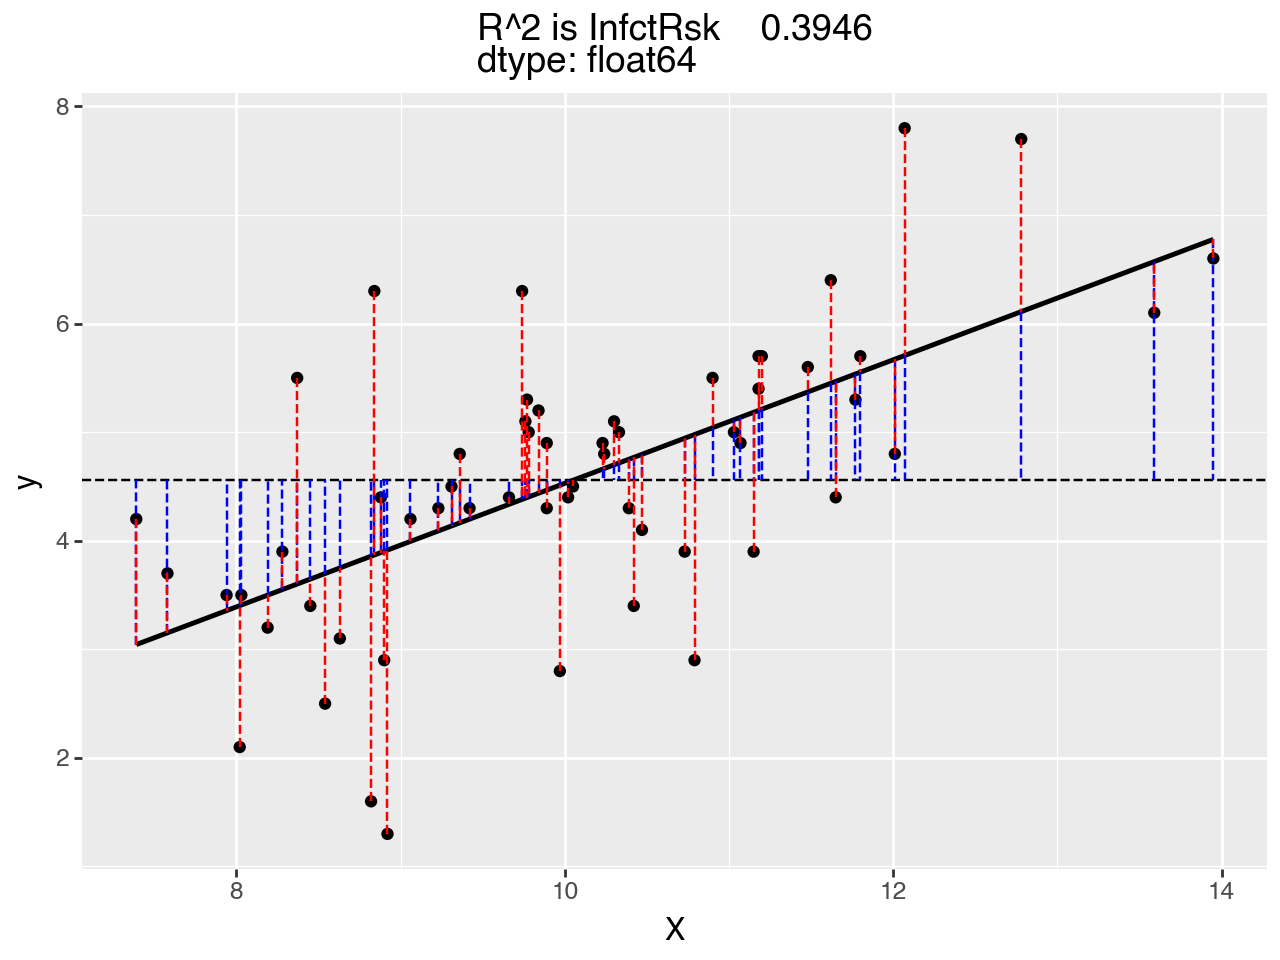

In [48]:
gg1.show()
gg2.show()

In [56]:
results = []
confidence_level = 0.95
X_with_const = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X_with_const).fit()

# Get the estimates for the intercept and slope
beta_0_hat = model.params[0]
beta_1_hat = model.params[1]

# Get the standard errors for the estimates
beta_0_se = model.bse[0]
beta_1_se = model.bse[1]

# Calculate the t-critical value
t_critical = stats.t.ppf((1 + confidence_level) / 2, df=n - 2)

# Calculate the confidence intervals for beta_0 and beta_1
beta_0_margin_of_error = t_critical * beta_0_se
beta_1_margin_of_error = t_critical * beta_1_se

beta_0_lower = beta_0_hat - beta_0_margin_of_error
beta_0_upper = beta_0_hat + beta_0_margin_of_error
beta_1_lower = beta_1_hat - beta_1_margin_of_error
beta_1_upper = beta_1_hat + beta_1_margin_of_error

# Check if the true values are within the confidence intervals
beta_0_contains_true = (beta_0_lower <= intercept <= beta_0_upper)
beta_1_contains_true = (beta_1_lower <= slope <= beta_1_upper)

# Color coding: Success if CI contains the true value, Miss otherwise
beta_0_color = 'Success' if beta_0_contains_true else 'Miss'
beta_1_color = 'Success' if beta_1_contains_true else 'Miss'

# Store the results
results.append({
    'Beta_0_Hat': beta_0_hat,
    'Beta_0_Lower': beta_0_lower,
    'Beta_0_Upper': beta_0_upper,
    'Beta_0_Contains': beta_0_contains_true,
    'Beta_0_Color': beta_0_color,
    'Beta_1_Hat': beta_1_hat,
    'Beta_1_Lower': beta_1_lower,
    'Beta_1_Upper': beta_1_upper,
    'Beta_1_Contains': beta_1_contains_true,
    'Beta_1_Color': beta_1_color
})

df_results = pd.DataFrame(results)
df_results

/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_65189/1180692793.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_65189/1180692793.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_65189/1180692793.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykern

,Beta_0_Hat,Beta_0_Lower,Beta_0_Upper,Beta_0_Contains,Beta_0_Color,Beta_1_Hat,Beta_1_Lower,Beta_1_Upper,Beta_1_Contains,Beta_1_Color
0,-1.159819,-3.074509,0.754871,[True],Success,0.568866,0.380233,0.757499,[True],Success


In [61]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

model = smf.ols(formula='InfctRsk ~ Stay', data=infections).fit()

# Generate the ANOVA table
anova_results = anova_lm(model)

# Display the ANOVA table
print(anova_results)

model.summary()

            df     sum_sq    mean_sq          F        PR(>F)
Stay       1.0  38.305918  38.305918  36.496522  1.302453e-07
Residual  56.0  58.776324   1.049577        NaN           NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               InfctRsk   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     36.50
Date:                Sun, 08 Sep 2024   Prob (F-statistic):           1.30e-07
Time:                        22:09:38   Log-Likelihood:                -82.684
No. Observations:                  58   AIC:                             169.4
Df Residuals:                      56   BIC:                             173.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1598      0.956     -1.213      0.230      -3.075       0.755
Stay           0.5689      0.094      6.041      0.000       0.380       0.757
==============================================================================
Omnibus:                        1.579   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.454   Jarque-Bera (JB):                0.839
Skew:                          -0.170   Prob(JB):                        0.657
Kurtosis:                       3.481   Cond. No.                         72.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
stay_time = 32

infection_predicted = intercept + slope * stay_time

print(f"Predicted infection risk for a stay of {stay_time} days: {infection_predicted}")

Predicted infection risk for a stay of 32 days: [17.04390764]


/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_65189/2535621212.py:11: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


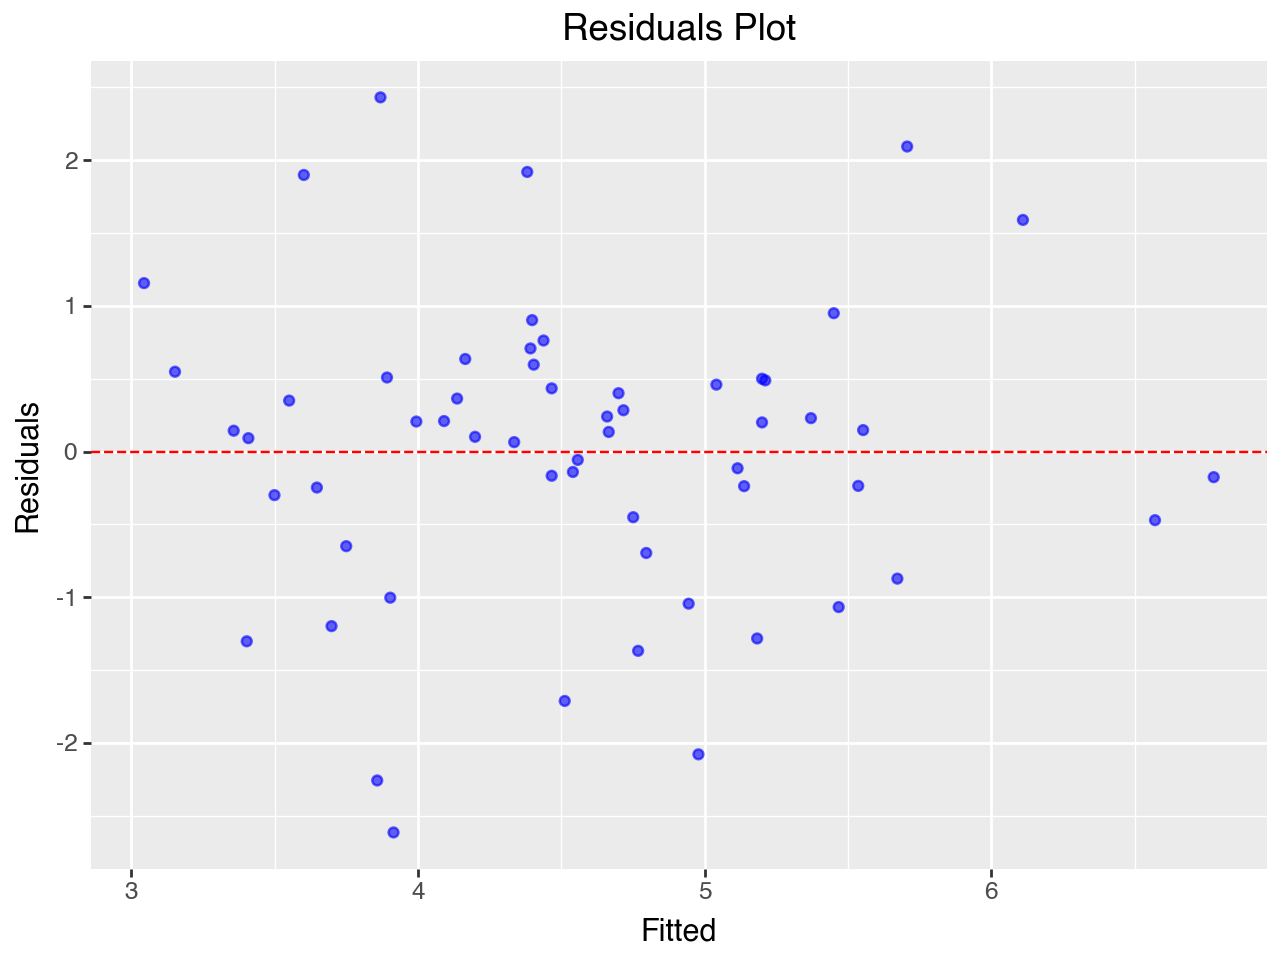

In [69]:
infections['Fitted'] = model.fittedvalues
infections['Residuals'] = model.resid

residual_plot = (
    ggplot(infections, aes(x='Fitted', y='Residuals')) +
    geom_point(color='blue', alpha=0.6) +
    geom_hline(yintercept=0, color='red', linetype='dashed') +
    labs(title='Residuals Plot')
)

print(residual_plot)

/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_65189/811040954.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


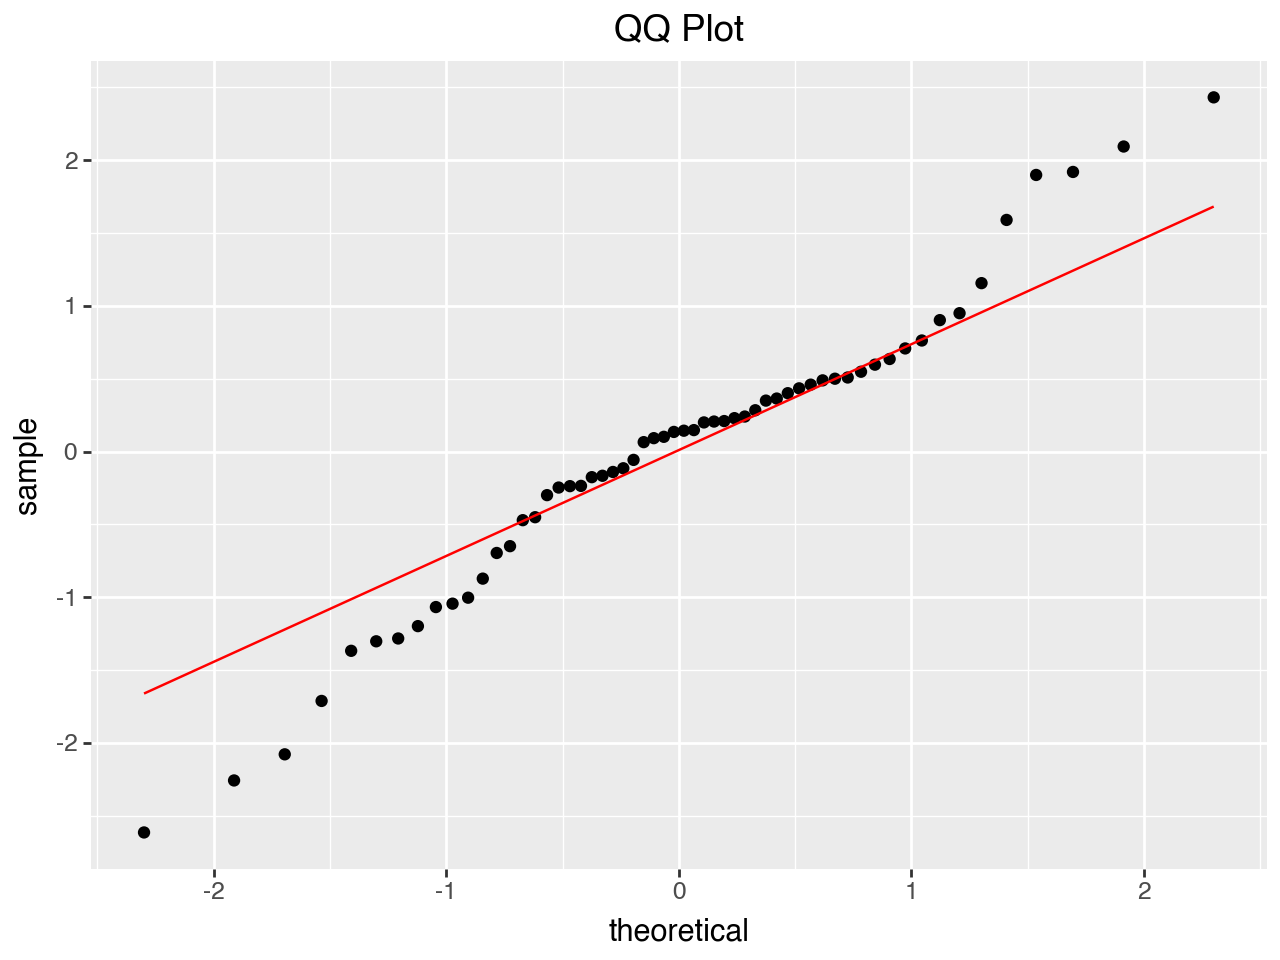

In [68]:
qq_plot = (
    ggplot(infections, aes(sample='Residuals')) +
    stat_qq() +
    stat_qq_line(color='red') +
    labs(title='QQ Plot')
)

print(qq_plot)

In [70]:
beta_hat = model.params

def yhat(x):
    return beta_hat[0] + beta_hat[1] * x

alpha = 0.05
n = len(infections)
crit = stats.t.ppf(1 - alpha/2, df=n-2)

sigma2hat = sum(model.resid**2) / (n - 2)
sigmahat = np.sqrt(sigma2hat)

x_values = infections['Stay']
xbar = np.mean(x_values)
SSX = sum((x_values - xbar)**2)

def seyhat(x):
    return sigmahat * np.sqrt(1/n + (x - xbar)**2 / SSX)

def seynew(x):
    return sigmahat * np.sqrt(1 + 1/n + (x - xbar)**2 / SSX)

x = 32
seyhat_value = seyhat(x)
seynew_value = seynew(x)

ci_mean = yhat(x) + np.array([-1, 1]) * crit * seyhat_value
print(f"95% CI for the mean infection risk when Stay = {x} days: {ci_mean.round(4)}")

pi_new = yhat(x) + np.array([-1, 1]) * crit * seynew_value
print(f"95% Prediction Interval for a new patient with Stay = {x} days: {pi_new.round(4)}")


95% CI for the mean infection risk when Stay = 32 days: [12.8945 21.1933]
95% Prediction Interval for a new patient with Stay = 32 days: [12.4147 21.6731]


/var/folders/86/c2gz31wn29b2r_53d_q3g3hc0000gn/T/ipykernel_65189/1894615563.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
